In [3]:
from io import StringIO
import sys
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd

Read in the dataframe. Before runnning SBS, apply MinMaxScaler and StandardScaler because we want to normalize/scale the data before fitting it into the SBS/KNN model.

In [5]:
header_list = ['SpMax_L', 'J_Dz(e)', 'nHM', 'F01[N-N]', 'F04[C-N]','NssssC', 'nCb-', 'C%', 'nCp', 'nO', 'F03[C-N]',
               'SdssC', 'HyWi_B(m)', 'LOC', 'SM6_L', 'F03[C-O]', 'Me', 'Mi', 'nN-N', 'nArNO2', 'nCRX3', 'SpPosA_B(p)', 
              'nCIR', 'B01[C-Br]', 'B03[C-Cl]', 'N-073', 'SpMax_A', 'Psi_i_1d', 'B04[C-Br]', 'SdO' , 'TI2_L', 'nCrt',
               'C-026', 'F02[C-N]', 'nHDon', 'SpMax_B(m)', 'Psi_i_A', 'nN', 'SM6_B(m)', 'nArCOOR', 'nX', 'TARGET']
data = pd.read_csv('BioDegData.csv', names = header_list)

columns = data.columns
data.head()

X, y = data.iloc[:, 0:-1].values, data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Normalizing the features to [0,1] using MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

# Standardizing the features using StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)


Implement the SBS class as given in the class code. The SBS contrusts a KNN to fit, transform, and calculate each metric/score based on a knn. 

In [6]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test =             train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Create a knn to later pass to the SBS class. 

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)

Create an SBS object with a knn with n_neighbors of 5. We then plot the number of features by the accuracy to see that there is best accuracy with between 25-35 features. 

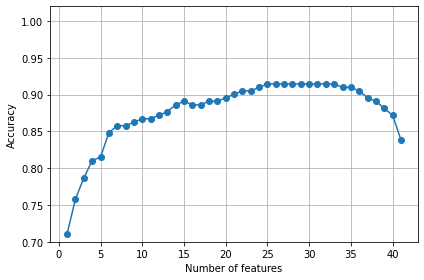

In [13]:
# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

First print out the accuracy for the entire dataset; then print out training & testing accuracies for the subset produced by the SBS. The training accuracy is about 1% higher and the testing accuracy is about 2% higher with SBS feature selection. 

In [11]:
k3 = list(sbs.subsets_[10])
print(data.columns[1:][k3])

knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Index(['J_Dz(e)', 'nHM', 'F01[N-N]', 'F04[C-N]', 'nCb-', 'C%', 'nCp', 'nO',
       'F03[C-N]', 'SdssC', 'HyWi_B(m)', 'LOC', 'SM6_L', 'F03[C-O]', 'Me',
       'Mi', 'nArNO2', 'nCRX3', 'SpPosA_B(p)', 'B01[C-Br]', 'Psi_i_1d',
       'TI2_L', 'C-026', 'F02[C-N]', 'nHDon', 'SpMax_B(m)', 'Psi_i_A', 'nN',
       'SM6_B(m)', 'nArCOOR', 'nX'],
      dtype='object')
Training accuracy: 0.8874407582938388
Test accuracy: 0.8530805687203792
Training accuracy: 0.8992890995260664
Test accuracy: 0.8767772511848341


Obtain the best features by using the API call on the SBS. 

(http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)